In [13]:
import numpy as np
from scipy import linalg
from scipy import optimize
import sympy as sm

To start with we will base our analysis on a standard Solow-model with technology growth, which we will later expand with human capital. Afterwards we will look at diffrent shocks to the economy and analyze them. First lets define our variables. We have the following:

1. $ K_{t}= Capital$
2. $L_t = Labor$
3. $A_t = Technology$
4. $Y_t = F(K_t,A_t,L_t) = GDP$

Where we have that $L_t$ is growing with the constant rate n and $A_t$ is growing with the constant rate g

The Solow Model consists of the following four equations.

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Population of size $L_t$ that grow with the rate $n$ in each period:

$$L_{t+1} = (1+n)L_{t}$$

Households supply labur $L_t$ exogenously and independant of wages.

**Households**: Households decide how much to save in order to buy both capital:
$$S_t = s Y_t$$
Consumption is income, $Y_t$ minus savings, $S_t$:
$$C_t = Y_t - S_t = (1 - s)Y_t$$


**Production:** Firms produce with a cobb douglas function. They use capital, $K_t$; labour, $L_t$ and technology, $A_t$

$$Y_{t} = K_{t}^\alpha(A_{t}L_{t})^{1-\alpha}$$

Capital accumulates at the saving rate and depreciates at the depreciation rate, $\delta$, which is exogenously given:
$$K_{t+1} = sY_{t}+(1-\delta)K_{t}$$

**Technology:** Technology accumulates at the rate, $g$.
$$A_{t+1} = (1+g)A_t$$

## Numerical solution and analysis 



**The transistion equation**

we find the transistion equation for kapital:

$$ \tilde{k}_{t+1} = \frac{1}{(1+n)(1+g)}(s \tilde{k}_t^\alpha+ (1-\delta)\tilde{k}_t)$$

**The Solow equation**

By substracting capital and human capital in period t, we get the solow equations:
$$ \tilde{k}_{t+1} - \tilde{k}_{t} = \frac{1}{(1+n)(1+g)}(s\tilde{k}_t^\alpha - (n + g + \delta + ng)\tilde{k}_t)$$

**Steady state**

In steady state, the change in capital and human capital is zero: 

$$ 0 = \frac{1}{(1+n)(1+g)}(s\tilde{k}_t^\alpha - (n + g + \delta + ng)\tilde{k}_t)$$

Here we have two equations with two unknowns. This is easy to solve with math and yieds: 

$$ \tilde{k}^* = \frac{s}{n+g+\delta+ng}^\frac{1}{1-\alpha}$$

Income is then: 

$$\tilde{y}^* = (\tilde{k}^*)^\alpha = \frac{s}{n+g+\delta+ng}^\frac{\alpha}{1-\alpha}$$

First we define our parameters

In [14]:
k = sm.symbols('k')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
s = sm.symbols('s')
g = sm.symbols('g')
n = sm.symbols('n')

From this we can write up our steady-state as code and solve for $ {k}^{\ast}$ with sympy

In [15]:
f=k**alpha
ss=sm.Eq(k,(s*f+(1-delta)*k)/((1+n)*(1+g)))
kss=sm.solve(ss,k)[0]
kss

((delta + g*n + g + n)/s)**(1/(alpha - 1))

Now we want to look at the capital accumaltion and how it reacts to a shock. We simualate a shoch were 50% of the capital is lost. This could be due to a earthquke or similar events. The equation we look at is
$$ \tilde{k}_{t+1} = \frac{1}{(1+n)(1+g)}(s \tilde{k}_t^\alpha+ (1-\delta)\tilde{k}_t)$$

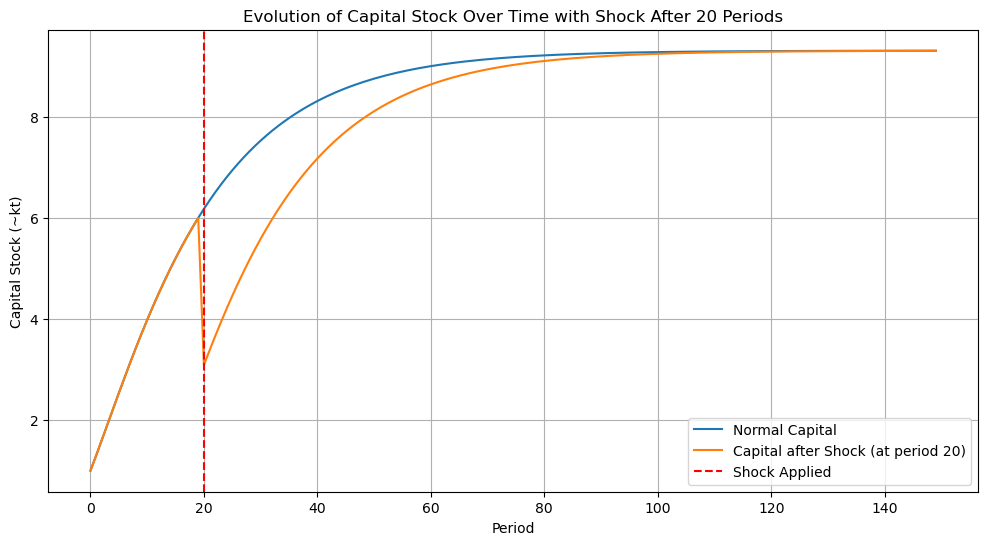

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 1/3
n = 0.02
g = 0.02
s = 0.4
delta = 0.05

# Simulation setup
periods = 150
threshold = 0.01 

def next_period_capital(k_tilde, s, alpha, delta, n, g):
    return (1 / ((1 + n) * (1 + g))) * (s * k_tilde**alpha + (1 - delta) * k_tilde)

# Initialize capital arrays
k_tilde_normal = np.zeros(periods)
k_tilde_shock = np.zeros(periods)
k_tilde_normal[0] = 1
k_tilde_shock[0] = 1

# Simulate the evolution of capital
for t in range(1, periods):
    k_tilde_normal[t] = next_period_capital(k_tilde_normal[t-1], s, alpha, delta, n, g)
    # Apply a 50% shock to the capital after 20 periods
    if t == 20:
        k_tilde_shock[t] = next_period_capital(k_tilde_shock[t-1], s, alpha, delta, n, g) * 0.5
    else:
        k_tilde_shock[t] = next_period_capital(k_tilde_shock[t-1], s, alpha, delta, n, g)

# Plotting the results with the shock after 20 periods
plt.figure(figsize=(12, 6))
plt.plot(k_tilde_normal, label='Normal Capital')
plt.plot(k_tilde_shock, label='Capital after Shock (at period 20)')
plt.axvline(x=20, color='red', linestyle='--', label='Shock Applied')
plt.xlabel('Period')
plt.ylabel('Capital Stock (\u007Ekt)')
plt.title('Evolution of Capital Stock Over Time with Shock After 20 Periods')
plt.legend()
plt.grid(True)
plt.show()



Above we have illustratede the normal capital without a shock and the capital with a shock after 20 periodes. Now we want to see how fast th capital will converganve towards the normal capital. In this sceanario we have decide to say the onvergence is complete when capital after the shock is within 1% of the capital without the shock

In [49]:
# Finding the convergenstime when the valus are within 1% of eachother

def find_convergence_time(k_normal, k_shock, threshold, start_period):
    for t in range(start_period, len(k_normal)):
        if np.abs(k_normal[t] - k_shock[t]) < threshold * k_normal[t]:
            return t
    return None

convergence_time = find_convergence_time(k_tilde_normal, k_tilde_shock, threshold, start_period=21)

print("The convergence time within a treshold of 1% is",convergence_time, "periods")


The convergence time within a treshold of 1% is 84 periods


As we can see, after 110 periode the capital is within 1% of the capital without shock. Which means the capital has as convergence time of 110 periods in our model

Now we will look at nummerical solution for the steady state

In [27]:
f = lambda k: k**alpha
obj_kss = lambda kss: kss - (s*f(kss) + (1-delta)*kss)/((1+g)*(1+n))
result = optimize.root_scalar(obj_kss,bracket=[0.1,100],method='brentq')
print('the steady state for k is',result.root) 

the steady state for k is 5.38484876650901


# Extension with human capital 

The Solow Model with human capital makes the following changes:

**Households**: Households decide how much to save in order to buy both capital and human capital:
$$S_t = (s_K + s_H)Y_t$$
Consumption is income, $Y_t$ minus savings, $S_t$:
$$C_t = Y_t - S_t = (1 - s_K - s_H)Y_t$$

**Production:** Firms produce with a cobb douglas function. They use capital, $K_t$; labour, $L_t$; technology, $A_t$ and human capital, $H_t$.

$$Y_{t} = K_{t}^\alpha H_{t}^\phi (A_{t}L_{t})^{1-\alpha-\phi}$$

Capital and human capital accumulates at the saving rats and depreciates at the depreciation rate, $\delta$, which is exogenously given:
$$K_{t+1} = s_{K}Y_{t}+(1-\delta)K_{t}$$
$$H_{t+1} = s_{H}Y_{t}+(1-\delta)H_{t}$$

**The transistion equation**

I can find the transistion equation for kapital and human capital:

$$ \tilde{k}_{t+1} = \frac{1}{(1+n)(1+g)}(s_K \tilde{k}_t^\alpha \tilde{h}_t^\phi + (1-\delta)\tilde{k}_t$$
$$ \tilde{h}_{t+1} = \frac{1}{(1+n)(1+g)}(s_H \tilde{k}_t^\alpha \tilde{h}_t^\phi + (1-\delta)\tilde{h}_t$$

**The Solow equation**

By substracting capital and human capital in period t, I get the solow equations:
$$ \tilde{k}_{t+1} - \tilde{k}_{t} = \frac{1}{(1+n)(1+g)}(s_K \tilde{k}_t^\alpha \tilde{h}_t^\phi - (n + g + \delta + ng)\tilde{k}_t$$
$$ \tilde{h}_{t+1} - \tilde{h}_{t} = \frac{1}{(1+n)(1+g)}(s_H \tilde{k}_t^\alpha \tilde{h}_t^\phi - (n + g + \delta + ng)\tilde{h}_t$$

**Steady state**

In steady state, the change in capital and human capital is zero: 

$$ 0 = \frac{1}{(1+n)(1+g)}(s_K \tilde{k}_t^\alpha \tilde{h}_t^\phi - (n + g + \delta + ng)\tilde{k}_t$$
$$ 0 = \frac{1}{(1+n)(1+g)}(s_H \tilde{k}_t^\alpha \tilde{h}_t^\phi - (n + g + \delta + ng)\tilde{h}_t$$

Here I have two equations with two unknowns. This is easy to solve with math and yieds: 

$$ \tilde{k}^* = \frac{s_K^{1-\phi}s_H^\phi}{n+g+\delta+ng}^\frac{1}{1-\alpha-\phi}$$
$$ \tilde{h}^* = \frac{s_K^{\alpha}s_H^{1-\alpha}}{n+g+\delta+ng}^\frac{1}{1-\alpha-\phi}$$

Income is then: 

$$\tilde{y}^* = (\tilde{k}^*)^\alpha (\tilde{h}^*)^\phi$$
$$= \frac{s_K}{n+g+\delta+ng}^\frac{\alpha}{1-\alpha-\phi} \frac{s_H}{n+g+\delta+ng}^\frac{\phi}{1-\alpha-\phi}$$

Parameters:

In [36]:
phi = sm.symbols('phi')
s_k = sm.symbols('s_k')
s_h = sm.symbols('s_h')


phi = 1/3
s_k = 0.2
s_h = 0.3

Now we solve steady state for both human capital and capital numerical by using fsolve from scipy.optimize The equations we solve are the following:
$$ \tilde{k}^* = \frac{s_K^{1-\phi}s_H^\phi}{n+g+\delta+ng}^\frac{1}{1-\alpha-\phi}$$
$$ \tilde{h}^* = \frac{s_K^{\alpha}s_H^{1-\alpha}}{n+g+\delta+ng}^\frac{1}{1-\alpha-\phi}$$

In [34]:
import numpy as np
from scipy.optimize import fsolve



# Define the system of equations using lambda functions
equations = lambda vars: [
    vars[0] - ((s_K**(1-phi)) * (s_H**phi) / (n + g + delta + n*g)) * (1 / (1 - alpha - phi)),
    vars[1] - ((s_K**alpha) * (s_H**(1-alpha)) / (n + g + delta + n*g)) * (1 / (1 - alpha - phi))
]

# Initial guesses for k and h
initial_guesses = [0.5, 0.5]

# Solve the equations
k_star, h_star = fsolve(equations, initial_guesses)

print(f'Steady state for k* is {k_star}')
print(f'Steady state for h* is {h_star}')


Steady state for k* is 11.371333535297994
Steady state for h* is 13.016927454679944


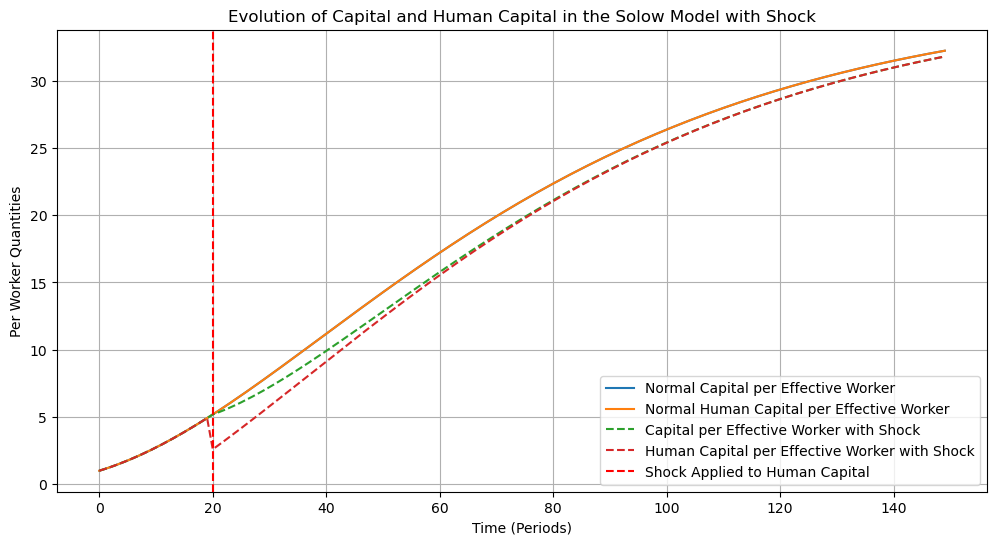

In [61]:
import numpy as np
import matplotlib.pyplot as plt



# Simulation setup
periods = 150
threshold = 0.01

def next_period_k(k_tilde, h_tilde, s_k, alpha, phi, delta, n, g):
    return ((s_k * k_tilde**alpha * h_tilde**phi) + (1 - delta) * k_tilde) / ((1 + n) * (1 + g))

def next_period_h(k_tilde, h_tilde, s_h, alpha, phi, delta, n, g):
    return ((s_h * k_tilde**alpha * h_tilde**phi) + (1 - delta) * h_tilde) / ((1 + n) * (1 + g))

# Initialize arrays for capital and human capital
k_tilde_new = np.zeros(periods)
h_tilde_new = np.zeros(periods)
k_tilde_new_shock = np.zeros(periods)
h_tilde_new_shock = np.zeros(periods)

k_tilde_new[0], h_tilde_new[0] = 1, 1  # Start with normalized values
k_tilde_new_shock[0], h_tilde_new_shock[0] = 1, 1   # Start with normalized values

# Simulate the evolution of capital and human capital
for t in range(1, periods):
    k_tilde_new[t] = next_period_k(k_tilde_new[t-1], h_tilde_new[t-1], s_k, alpha, phi, delta, n, g)
    h_tilde_new[t] = next_period_h(k_tilde_new[t-1], h_tilde_new[t-1], s_h, alpha, phi, delta, n, g)
    
    # Compute next values for the shock scenario
    k_tilde_new_shock[t] = next_period_k(k_tilde_new_shock[t-1], h_tilde_new_shock[t-1], s_k, alpha, phi, delta, n, g)
    h_tilde_new_shock[t] = next_period_h(k_tilde_new_shock[t-1], h_tilde_new_shock[t-1], s_h, alpha, phi, delta, n, g)
    
    # Apply a 20% shock to human capital after 20 periods
    if t == 20:
        h_tilde_new_shock[t] *= 0.50

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(k_tilde_new, label='Normal Capital per Effective Worker')
plt.plot(h_tilde_new, label='Normal Human Capital per Effective Worker')
plt.plot(k_tilde_new_shock, '--', label='Capital per Effective Worker with Shock')
plt.plot(h_tilde_new_shock, '--', label='Human Capital per Effective Worker with Shock')
plt.axvline(x=20, color='red', linestyle='--', label='Shock Applied to Human Capital')
plt.xlabel('Time (Periods)')
plt.ylabel('Per Worker Quantities')
plt.title('Evolution of Capital and Human Capital in the Solow Model with Shock')
plt.legend()
plt.grid(True)
plt.show()


In [70]:

import numpy as np

def find_convergence_time(threshold, periods, s_k, s_h, alpha, phi, delta, n, g):
    k_tilde_new = np.zeros(periods)
    h_tilde_new = np.zeros(periods)
    
    k_tilde_new[0], h_tilde_new[0] = 1, 1  # Start with normalized values
    
    convergence_time = None
    for t in range(1, periods):
        k_tilde_new[t] = next_period_k(k_tilde_new[t-1], h_tilde_new[t-1], s_k, alpha, phi, delta, n, g)
        h_tilde_new[t] = next_period_h(k_tilde_new[t-1], h_tilde_new[t-1], s_h, alpha, phi, delta, n, g)
        
        # Check convergence for human capital
        if t > 1 and abs(h_tilde_new[t] - h_tilde_new[t-1]) < threshold:
            convergence_time = t
            break
    
    return convergence_time


# Find convergence time
convergence_time = find_convergence_time(threshold, periods, s_k, s_h, alpha, phi, delta, n, g)

if convergence_time is not None:
    print("Convergence time for human capital:", convergence_time)
else:
    print("Human capital did not converge within the given threshold.")


Convergence time for human capital: 62
